<a href="https://colab.research.google.com/github/OdysseusPolymetis/enssib_class/blob/main/2_Stylometry_Moliere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stylométrie sur Molière et d'autres**
Ce code est extrait du papier suivant, écrit par Florian Cafiero et Jean-Baptiste Camps en 2019: https://pmc.ncbi.nlm.nih.gov/articles/PMC6881153/
<br>Voilà en gros ce qui s'y passe:
<br>À chaque fois, on fait :

- Matrice de comptes features × textes
(ex : “lemme négliger” × “Moliere_Tartuffe”)

- Sélection de features
select <- selection(theatre, z = 1.645)[,4]
→ on garde les traits jugés les plus discriminants/stables selon leur procédure.

- Fréquences relatives
theatre2 <- relativeFreqs(theatre)
→ on corrige (en partie) l'effet “textes plus longs”.

- Normalisations = l'étape “Burrows”
theatre2 <- normalisations(theatre2)
C'est ici que se fait l'esprit “Burrows/Delta” :

on centre-réduit les features (z-scores par feature, typiquement),

et on applique la normalisation de longueur de vecteur (“vector-length norm”) dont ils parlent,

bref : on transforme des fréquences en profils stylistiques comparables.

- Distance + clustering

## Pourquoi je vous parle de ça ?
Camps & Cafiero contredisent ici le papier de Dominique (et Cyril) Labbé sur “Molière = Corneille”

La “thèse cornélienne” remise au goût du jour par la stylométrie vient surtout de :

Cyril & Dominique Labbé (2001), _Inter-Textual Distance and Authorship Attribution: Corneille and Molière_ (Journal of Quantitative Linguistics) : ils proposent une “distance intertextuelle” basée sur des fréquences de mots et l'appliquent au cas Corneille/Molière, concluant à une très forte proximité (et, chez eux, à une contribution de Corneille).
Dominique Labbé (2009), ouvrage grand public _Si deux et deux sont quatre, Molière n’a pas écrit Dom Juan…_ qui popularise la thèse.

<br>Personnellement, quand je n'ai pas le moral et que j'ai besoin de me rappeler qu'il existe des chercheurs aigris et grincheux, je vais sur ce lien, et je ne résiste pas au plaisir de vous en lire des extraits (outre que ledit chercheur montre qu'il ne sait pas programmer tout seul, puisque vous pouvez reproduire les expériences en direct ci-dessous). Voici donc : https://www.pileface.com/sollers/pdf/LabbRponseCafieroCamps.pdf


In [ ]:
install.packages(c("tidyverse", "readr", "stringr", "cluster", "dendextend","curl","rmarkdown", "knitr","ggfortify","NMF"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“dependency ‘Biobase’ is not available”
also installing the dependencies ‘iterators’, ‘plyr’, ‘registry’, ‘rngtools’, ‘gridBase’, ‘colorspace’, ‘foreach’, ‘doParallel’, ‘reshape2’, ‘BiocManager’


Warning message in install.packages(c("tidyverse", "readr", "stringr", "cluster", :
“installation of package ‘NMF’ had non-zero exit status”


In [ ]:
library(tidyverse)
library(cluster)
library(dendextend)
library(curl)

In [ ]:
url <- "https://github.com/OdysseusPolymetis/digital_classics_course/raw/refs/heads/main/aax5489_Data_file_S3.zip"

dir.create("data", showWarnings = FALSE)
zip_path <- "data/aax5489_Data_file_S3.zip"
out_dir  <- "data/aax5489_S3"

download.file(url, zip_path, mode = "wb")
unzip(zip_path, exdir = out_dir, overwrite = TRUE)

S3_DIR <- file.path(out_dir, "DataS3_datasets-and-scripts")
stopifnot(dir.exists(S3_DIR))
list.files(S3_DIR)[1:20]


[1] "analysis_controlCorpus.html" "analysis_controlCorpus.Rmd" 
 [3] "analysis_explorat.html"      "analysis_explorat.Rmd"      
 [5] "analysis_subgroup.html"      "analysis_subgroup.Rmd"      
 [7] "control-lemma.csv"           "control-POS3gr.csv"         
 [9] "control-rhymes.csv"          "control-words.csv"          
[11] "explorat-lemma.csv"          "explorat-POS3gr.csv"        
[13] "explorat-rhymes.csv"         "explorat-words.csv"         
[15] "function_words.txt"          "functions.R"                
[17] "suspected_proper_names.txt"  NA                           
[19] NA                            NA

In [ ]:
install.packages(c(
  "cluster", "dendextend",
  "ggplot2", "gridExtra",
  "readr", "stringr"
))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
setwd(S3_DIR)

needed <- c("functions.R", "suspected_proper_names.txt", "function_words.txt",
            "explorat-lemma.csv", "explorat-rhymes.csv", "explorat-words.csv", "explorat-POS3gr.csv")

needed[file.exists(needed)]
stopifnot(all(file.exists(needed)))

[1] "functions.R"                "suspected_proper_names.txt"
[3] "function_words.txt"         "explorat-lemma.csv"        
[5] "explorat-rhymes.csv"        "explorat-words.csv"        
[7] "explorat-POS3gr.csv"

In [ ]:
source("functions.R")

exists("selection")
exists("relativeFreqs")
exists("normalisations")
exists("cahPlot")

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

Ici on construit une liste de textes/pièces (identifiants) qui vont servir dans l'expérience.

Les préfixes indiquent les auteurs :

CORNEILLEP = Pierre Corneille

CORNEILLET = Thomas Corneille

MOLIERE, ROTROU, SCARRON = autres dramaturges du XVIIe

C'est typiquement le "panel" sur lequel on va :

- construire des profils stylistiques

- entraîner/évaluer une attribution d'auteur (classification, distances, etc.)

In [ ]:
stopifnot(file.exists("functions.R"))
stopifnot(file.exists("suspected_proper_names.txt"))
stopifnot(file.exists("function_words.txt"))

source("functions.R")

suspectedProperNames <- scan("suspected_proper_names.txt", what = "character", sep = ",")
functionWords <- scan("function_words.txt", what = "character")

subgroup <- c(
"CORNEILLEP_GALERIEDUPALAIS", "CORNEILLEP_ILLUSIONCOMIQUE", "CORNEILLEP_MELITE33",
"CORNEILLEP_MENTEUR", "CORNEILLEP_PLACEROYALE", "CORNEILLEP_SUITEMENTEUR",
"CORNEILLEP_SUIVANTE","CORNEILLEP_VEUVE34",
"CORNEILLET_AMOURALAMODE", "CORNEILLET_CHARMEDELAVOIX", "CORNEILLET_COMTESSEORGUEIL",
"CORNEILLET_DOMBERTRANDECIGARRAL", "CORNEILLET_DOMCESARDAVALOS","CORNEILLET_FEINTASTROLOGUE",
"CORNEILLET_FESTINPIERRE", "CORNEILLET_GALANTDOUBLE", "CORNEILLET_GEOLIERDESOISMEME",
"CORNEILLET_INCONNU",
"MOLIERE_DEPITAMOUREUX","MOLIERE_ECOLEDESFEMMES", "MOLIERE_ETOURDI",
"MOLIERE_FEMMESSAVANTES", "MOLIERE_MISANTHROPE", "MOLIERE_TARTUFFE",
"ROTROU_BAGUEDELOUBLI", "ROTROU_BELLEALPHREDE", "ROTROU_CAPTIFS", "ROTROU_SOSIES",
"SCARRON_DOMJAPHETDARMENIE", "SCARRON_GARDIENDESOIMEME", "SCARRON_HERITIERRIDICULE",
"SCARRON_JODELET", "SCARRON_JODELETDUELISTE", "SCARRON_MARQUISRIDICULE",
"MOLIERE_ECOLEDESMARIS", "MOLIERE_AMPHITRYON", "MOLIERE_FACHEUX"
)

length(subgroup)

[1] 37

Cette cellule sert à **préparer des outils** (des "petites fonctions") pour **comprendre le corpus** avant de lancer les analyses stylométriques.
<br>Les textes ont des identifiants du type `MOLIERE_TARTUFFE` ou `CORNEILLEP_MENTEUR`.

On définit une fonction qui récupère automatiquement le **préfixe** (`MOLIERE`, `CORNEILLEP`, etc.), ce qui correspond ici à l'**auteur**.

Pourquoi ? Pour pouvoir ensuite regrouper les résultats **par auteur** dans les graphiques.
<br>On définit une fonction qui produit un graphique montrant, pour chaque auteur, la **distribution des longueurs des textes** (nombre total de tokens comptés).

Le graphique combine :
- un **violon** (forme de distribution)
- une **boîte à moustaches** (médiane + dispersion)

Pourquoi c'est important ?
- Des textes très longs et très courts ne se comparent pas toujours bien.
- En stylométrie, la longueur peut influencer la stabilité des fréquences (un texte court est souvent plus "bruyant").
- Ce graphique permet donc de repérer des **déséquilibres** dans le corpus avant d'aller plus loin.
<br><br>On définit aussi une fonction pour tracer la distribution d'un trait (par ex. la fréquence relative d'un mot-outil) en fonction :
- d'un **cluster** (un groupe de textes obtenu par une méthode de regroupement)
- et de l'**auteur** (pour garder une lecture interprétable)

Pourquoi ?
- Pour voir si certains traits stylistiques sont **surreprésentés** dans un groupe de textes.
- Et pour aider à interpréter ce que "signifient" les clusters : groupes par auteur ? par genre ? par période ? etc.





In [ ]:
library(dplyr)
library(stringr)
library(ggplot2)

get_author <- function(id) {
  # Exemple: MOLIERE_TARTUFFE -> MOLIERE
  str_extract(id, "^[A-Z]+")
}

plot_text_lengths <- function(mat, title = "Text lengths (tokens)") {
  df <- tibble(text = colnames(mat), tokens = colSums(mat)) %>%
    mutate(author = get_author(text))
  ggplot(df, aes(x = author, y = tokens)) +
    geom_violin() +
    geom_boxplot(width = 0.15) +
    labs(title = title, x = "", y = "Nb. tokens") +
    theme_minimal()
}

plot_feature_by_cluster <- function(relFreq_row, clusters, feat_name) {
  df <- tibble(
    text = colnames(relFreq_row),
    value = as.numeric(relFreq_row[1, ]),
    cluster = factor(clusters),
    author = get_author(colnames(relFreq_row))
  )
  ggplot(df, aes(x = cluster, y = value)) +
    geom_violin() +
    geom_boxplot(width = 0.15) +
    labs(title = paste("Feature:", feat_name), x = "Cluster", y = "Relative frequency") +
    theme_minimal()
}

Dans la cellule qui suit, on prépare une matrice de données stylométriques à partir des lemmes, puis on applique un **clustering** (regroupement automatique) pour voir quels textes se ressemblent.

1) **On charge les données**
- On lit un fichier où chaque ligne = un **lemme** (mot "dictionnaire"),
- chaque colonne = un **texte**,
- et les nombres = combien de fois le lemme apparaît dans le texte.

2) **On garde seulement les textes qui nous intéressent**
- On sélectionne les pièces listées dans `subgroup`.

3) **On nettoie**
- On enlève les **noms propres** (personnages, lieux…), parce que ça reflète surtout le **sujet** du texte, pas le style.
- On enlève aussi les lignes vides (lemmes qui ne restent dans aucun texte).

4) **On choisit les lemmes les plus utiles**
- On ne garde qu'un sous-ensemble de lemmes "intéressants" pour distinguer les textes.
- Ça évite le bruit et ça rend l'analyse plus claire.

5) **On met les données en “proportions”**
- On transforme les comptes en **fréquences relatives** (pour comparer des textes de longueurs différentes).

6) **On normalise**
- On met les variables sur une échelle comparable (pour éviter qu'un trait domine juste parce qu'il est plus fréquent).

7) **On regroupe les textes automatiquement (clustering)**
- On calcule des ressemblances entre textes et on construit un **dendrogramme** (un arbre de regroupement).

8) **On affiche 5 groupes**
- On découpe l'arbre en **5 clusters** pour voir si les textes se regroupent “naturellement” (souvent, on compare ensuite avec les auteurs : est-ce que chaque auteur forme un groupe ?).

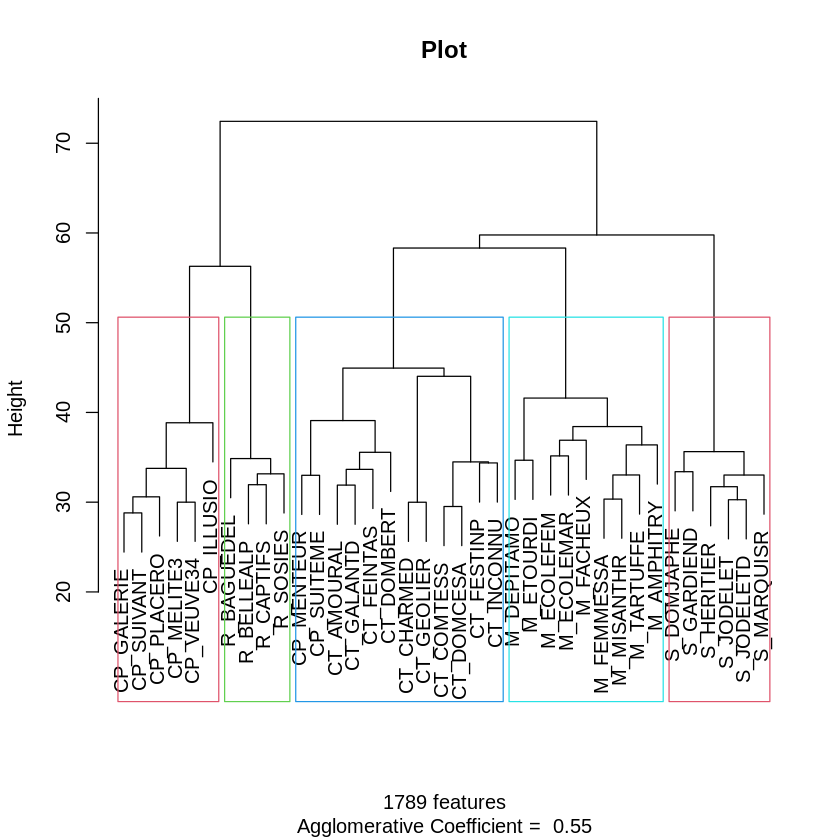

In [ ]:
theatreLemma <- as.matrix(read.csv("explorat-lemma.csv", sep = ";", header = TRUE, row.names = 1, quote="\""))

theatre <- theatreLemma[, subgroup]
theatre <- theatre[!rownames(theatre) %in% suspectedProperNames, ]
theatre <- theatre[rowSums(theatre) > 0, ]

select <- selection(theatre, z = 1.645)[,4]

theatre2 <- relativeFreqs(theatre)
theatreLemmaSave <- theatre2
theatre2 <- theatre2[select, ]
theatre2 <- normalisations(theatre2)

CAHLemma <- cluster::agnes(t(theatre2), metric = "manhattan", method = "ward")

cahPlot(CAHLemma, k = 5)


Le clustering hiérarchique a produit un “arbre” (dendrogramme).  
Ici, on **coupe l'arbre en 5 clusters** pour donner à chaque texte une étiquette de groupe (cluster 1, 2, 3, 4 ou 5).
On prend un lemme à regarder (ici, **"négliger"** si présent, sinon un lemme au hasard).
On trace un graphique qui montre, pour chaque cluster :
- la **distribution** de la fréquence relative du lemme choisi
- texte par texte

Pourquoi ?
- Pour voir si certains clusters se caractérisent par une **sur- ou sous-utilisation** de ce lemme.
- Ça aide à interpréter ce que représente un cluster.
<br>On récupère l'auteur de chaque texte (à partir de son identifiant), puis on construit un tableau :

- lignes = **auteurs**
- colonnes = **clusters**
- valeurs = **combien de textes** de chaque auteur tombent dans chaque cluster
On transforme ce tableau en **pourcentages**, cluster par cluster.

Lecture typique :
- Si un cluster est à 80–100% composé d'un seul auteur, le clustering a "retrouvé" une structure proche de l'auteur.
- Si chaque cluster mélange beaucoup d'auteurs, le regroupement ne suit pas fortement l'auteur (ou bien d'autres facteurs dominent : genre, période, longueur, etc.).



            cluster
author       1 2 3 4 5
  CORNEILLEP 6 2 0 0 0
  CORNEILLET 0 2 8 0 0
  MOLIERE    0 0 4 2 3
  ROTROU     0 0 0 4 0
  SCARRON    0 0 0 3 3

            cluster
author               1         2         3         4         5
  CORNEILLEP 1.0000000 0.5000000 0.0000000 0.0000000 0.0000000
  CORNEILLET 0.0000000 0.5000000 0.6666667 0.0000000 0.0000000
  MOLIERE    0.0000000 0.0000000 0.3333333 0.2222222 0.5000000
  ROTROU     0.0000000 0.0000000 0.0000000 0.4444444 0.0000000
  SCARRON    0.0000000 0.0000000 0.0000000 0.3333333 0.5000000

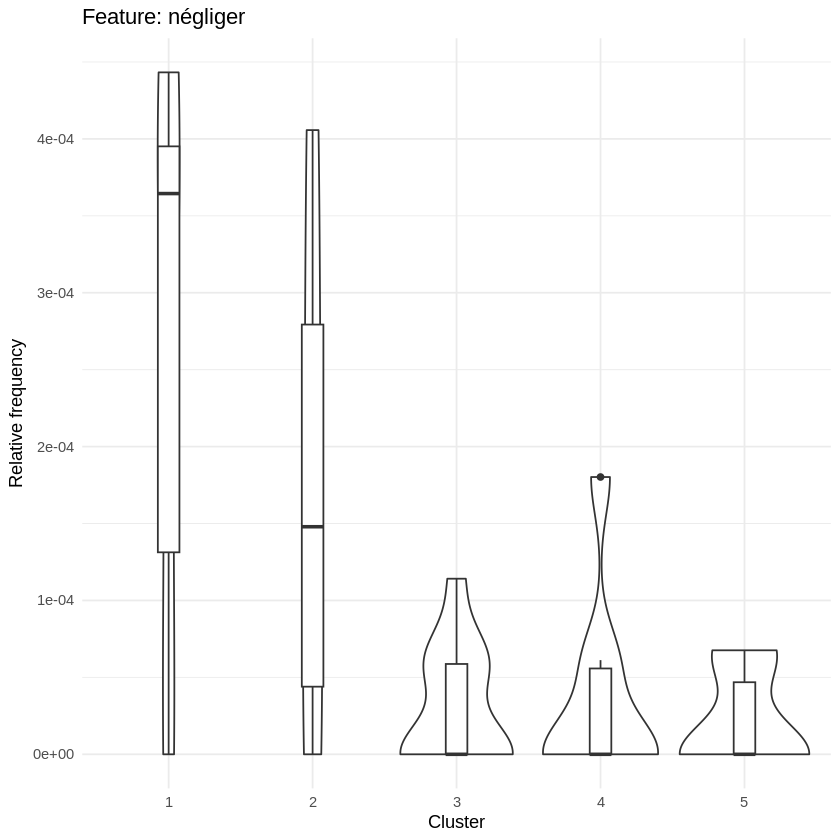

In [ ]:
clusters <- dendextend::cutree(as.hclust(CAHLemma), k = 5, order_clusters_as_data = FALSE)

# Exemple: prendre une feature fréquente, ici "négliger"
feat <- if ("négliger" %in% rownames(theatreLemmaSave)) "négliger" else rownames(theatreLemmaSave)[1]
p <- plot_feature_by_cluster(theatreLemmaSave[feat, , drop=FALSE], clusters, feat)
print(p)
texts <- colnames(theatreLemmaSave)
authors <- get_author(texts)
tab <- table(author = authors, cluster = clusters)
tab
prop.table(tab, margin = 2)

Sur les lemmes, on a un signal d'auteur, mais pas parfaitement : Molière se disperse. Donc : les lemmes ne sont pas la meilleure représentation du style.

Ensuite, on refait **exactement la même démarche que pour les lemmes**, mais avec un autre type de "traits" : des **trigrammes de catégories grammaticales (POS)**.

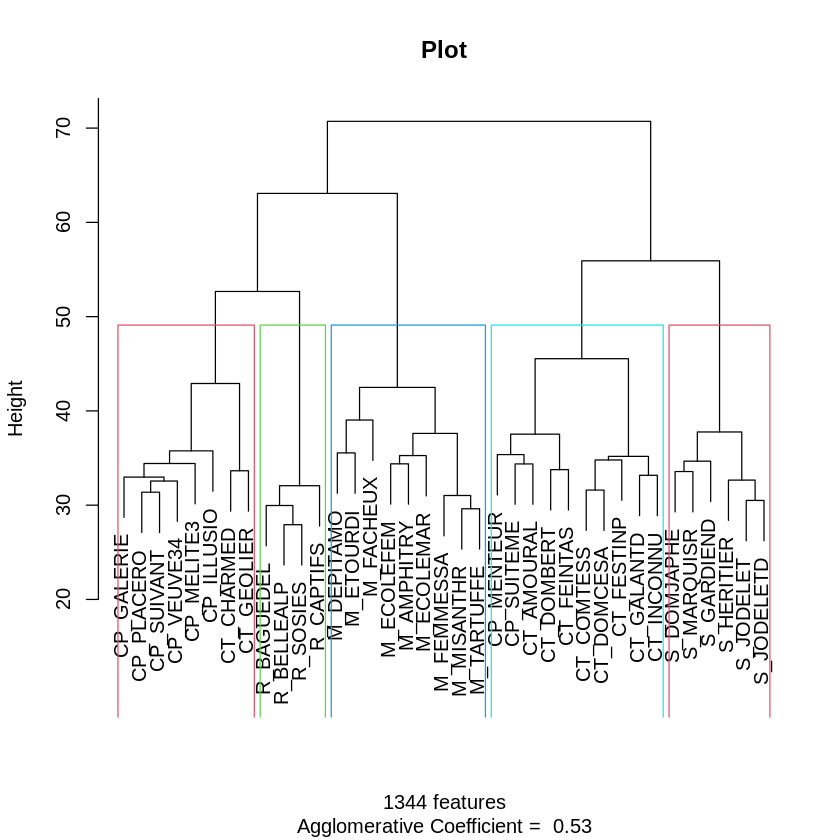

In [ ]:
theatreTrigrW <- as.matrix(read.csv("explorat-POS3gr.csv", sep = ";", header = TRUE, row.names = 1, quote="\""))

theatre <- theatreTrigrW[, subgroup]
theatre <- theatre[rowSums(theatre) > 0, ]

select <- selection(theatre, z = 1.645)[,4]

theatre2 <- relativeFreqs(theatre)
theatrePOS3grSave <- theatre2
theatre2 <- theatre2[select, ]
theatre2 <- normalisations(theatre2)

CAHPOS3gr <- cluster::agnes(t(theatre2), metric = "manhattan", method = "ward")

cahPlot(CAHPOS3gr, k = 5)

1344 features (moins que les lemmes), coefficient agglomératif 0.53 (structure moyenne, similaire).

Les rectangles = la coupe en 5 clusters.

Cluster (rectangle bleu, au centre-gauche) : Molière très compact

On voit quasiment tous les M_... ensemble :

M_DEPITAMO, M_ETOURDI, M_FACHEUX, M_ECOLEF, M_FEM, M_ECOLEM, M_ECOLESF, M_MISANTH, M_TARTUFFE, M_AMPHITRY…

Sur les patrons grammaticaux, les pièces de Molière sont très similaires entre elles et forment un groupe net.

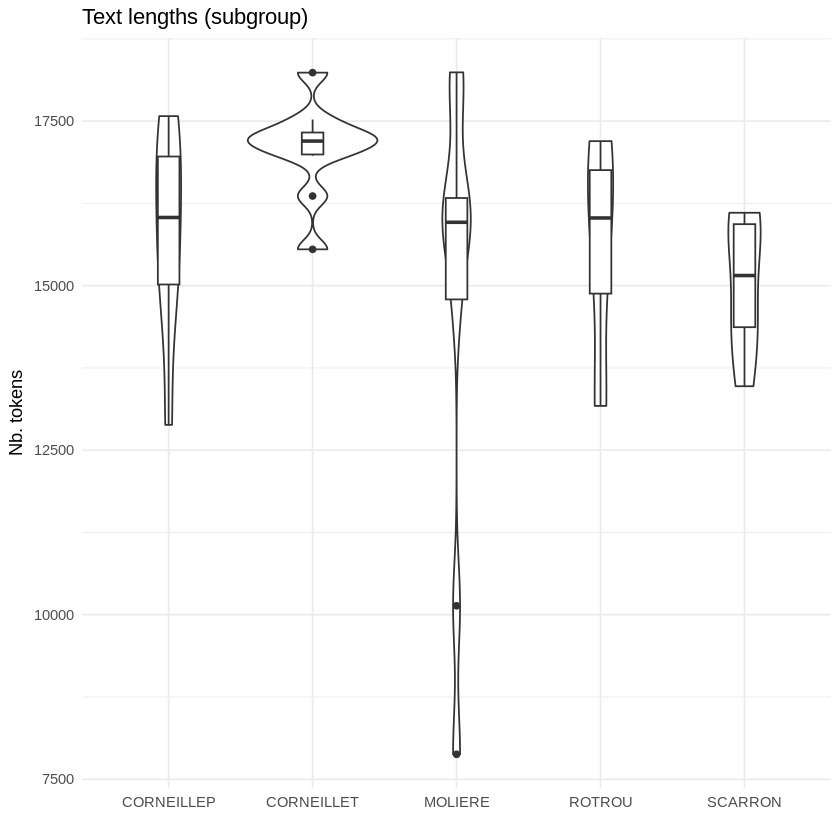

            cluster
author               1         2         3         4         5
  CORNEILLEP 1.0000000 0.0000000 0.0000000 0.0000000 0.0000000
  CORNEILLET 0.0000000 1.0000000 1.0000000 0.0000000 0.0000000
  MOLIERE    0.0000000 0.0000000 0.0000000 0.6000000 0.3333333
  ROTROU     0.0000000 0.0000000 0.0000000 0.4000000 0.0000000
  SCARRON    0.0000000 0.0000000 0.0000000 0.0000000 0.6666667

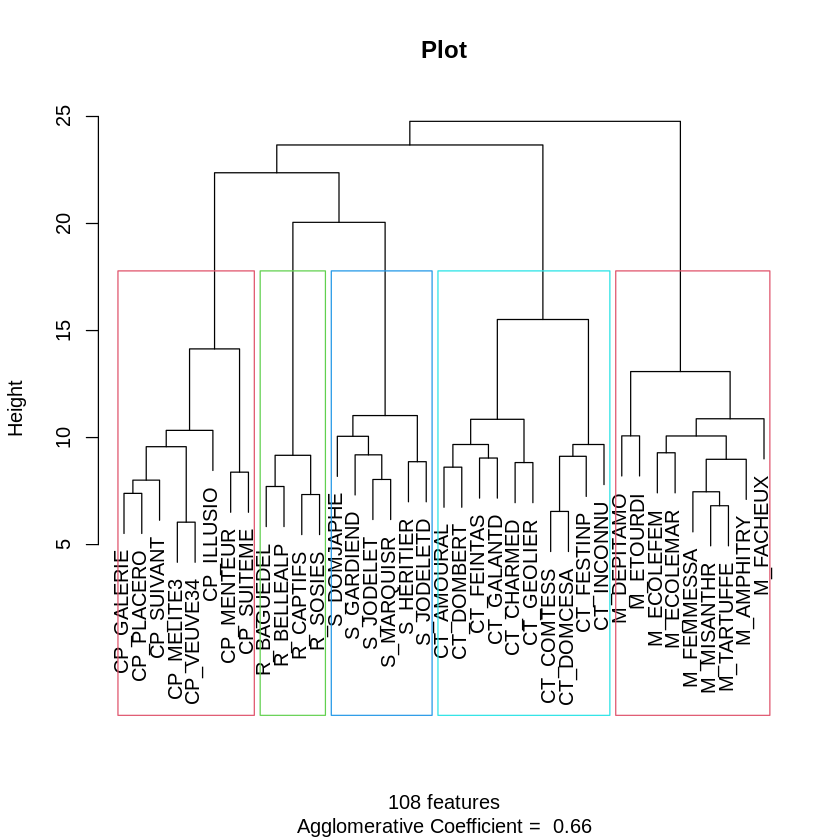

In [ ]:
theatreAllWords <- as.matrix(read.csv("explorat-words.csv", sep = ";", header = TRUE, row.names = 1, quote="\""))

theatre <- theatreAllWords[, subgroup]
theatre <- theatre[!rownames(theatre) %in% suspectedProperNames, ]
theatre <- theatre[rowSums(theatre) > 0, ]

print(plot_text_lengths(theatre, "Text lengths (subgroup)"))

theatre2 <- theatre[order(rowSums(theatre), decreasing = TRUE), ]
theatre2 <- relativeFreqs(theatre2)
theatre2 <- theatre2[rownames(theatre2) %in% functionWords, ]

theatreFWSave <- theatre2
theatre2 <- normalisations(theatre2)

CAHmfw <- cluster::agnes(t(theatre2), metric = "manhattan", method = "ward")

cahPlot(CAHmfw, k = 5)

clusters_fw <- dendextend::cutree(as.hclust(CAHmfw), k = 5, order_clusters_as_data = FALSE)

texts_fw <- colnames(theatreFWSave)
authors_fw <- get_author(texts_fw)

tab_fw <- table(author = authors_fw, cluster = clusters_fw)
prop.table(tab_fw, margin = 2)

## Interprétation synthétique (violons + clustering "mots-outils")

### 1) Longueur des textes (figure en violons)
- Les violons montrent la **répartition des longueurs** (nombre de tokens) par auteur.
- Globalement, les textes ont des tailles **comparables** (≈ 15k–17.5k tokens), ce qui rend la comparaison plus fiable.
- Deux pièces de **Molière** sont nettement plus courtes (≈ 8k–10k) : même en fréquences relatives, les textes courts peuvent être plus “bruités”, d'où l'intérêt des normalisations.

### 2) Clustering sur les mots-outils (function words)
- On transforme les comptages en **fréquences relatives**, on ne garde que les **mots-outils**, puis on normalise et on fait un **clustering hiérarchique**.
- Résultat : les groupes sont **très structurés** :
  - **Pierre Corneille** forme un cluster "pur".
  - **Thomas Corneille** occupe **deux clusters**, mais **sans mélange** avec les autres auteurs (deux sous-styles possibles, mais toujours "Thomas Corneille").

### 3) Conclusion stylistique
- Point crucial : **aucune pièce de Molière** ne tombe dans les clusters des **Corneille** → cela va **contre** l'idée “Molière = Corneille”.
- En revanche, Molière peut parfois se rapprocher de **Rotrou** ou **Scarron** : proximité plausible (genre/registre/période), ce qui rappelle que la stylométrie capte aussi des **facteurs littéraires** en plus de l'auteur.


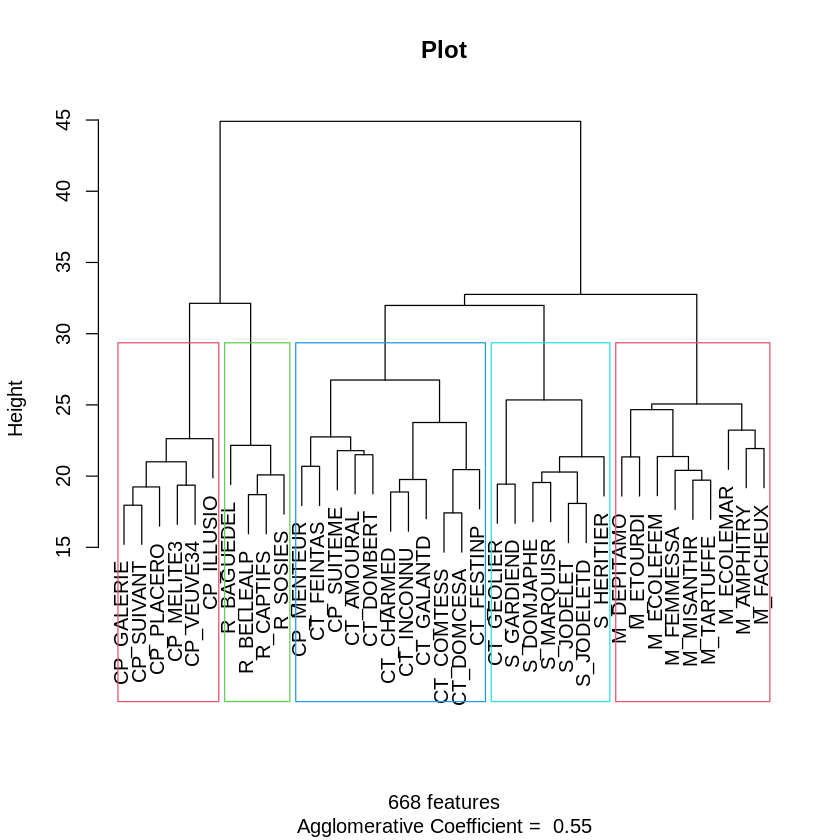

In [ ]:
theatreLemmaRim <- as.matrix(read.csv("explorat-rhymes.csv", sep = ";", header = TRUE, row.names = 1, quote="\""))

theatre <- theatreLemmaRim[, subgroup]
theatre <- theatre[!rownames(theatre) %in% suspectedProperNames, ]
theatre <- theatre[rowSums(theatre) > 0, ]

select <- selection(theatre, z = 1.645)[,4]

theatre2 <- relativeFreqs(theatre)
theatreRhymesSave <- theatre2
theatre2 <- theatre2[select, ]
theatre2 <- normalisations(theatre2)

CAHRhyme <- cluster::agnes(t(theatre2), metric = "manhattan", method = "ward")

cahPlot(CAHRhyme, k = 5)

Cluster rouge (tout à gauche) : Pierre Corneille (CP)

On voit CP_GALERIE, CP_SUIVANT, CP_PLACERO, CP_MELITE3, CP_VEUVE34 ensemble.
👉 Ici, CorneilleP est cohérent.

CP_ILLUSIO est juste à côté, mais il semble tomber dans le cluster bleu (pas dans le rouge).
➡️ C’est intéressant : selon les rimes, Illusion comique se comporte un peu différemment du reste de CorneilleP.

Cluster vert : Rotrou

R_BAGUEDEL, R_BELLEAL, R_CAPTIFS, R_SOSIES sont ensemble.
👉 Cluster auteur très net.

Cluster bleu (au centre-gauche) : mix CorneilleP + Thomas Corneille

On voit clairement :

CP_ILLUSIO, CP_MENTEUR, CP_SUITEME (CorneilleP)

et à côté une grande série CT_... (Thomas Corneille)

👉 Donc ce cluster capte une proximité “CorneilleP ↔ CorneilleT” sur ce trait “rimes”.
C’est très plausible : mêmes milieux, mêmes pratiques théâtrales/poétiques, même époque, etc.
Et surtout : ça rappelle que “rime” est un lieu où les conventions (formes attendues) peuvent dominer la signature individuelle.

Cluster cyan (centre-droit) : Scarron + quelques CorneilleT

Le rectangle cyan contient beaucoup de S_... (Scarron), mais aussi CT_GEOLIE et CT_FESTIN qui semblent tomber de ce côté (selon l’étiquette visible).
👉 Donc Scarron forme un noyau, mais certains Thomas Corneille se rapprochent sur la rime.

➡️ Là encore : cohérent si ces pièces partagent une forme/registre (comédie, rimes fréquentes, lexique de rime, etc.).

Cluster rouge (tout à droite) : Molière très net

On voit toutes les étiquettes M_... groupées ensemble (M_DEPITAMO, M_ETOURDI, M_ECOLEF, M_ECOLEM, M_ECOLESF, M_FEM, M_MISANTH, M_TARTUFFE, M_AMPHITRY, M_FACHEUX).
👉 Ici, Molière ressort comme un cluster très cohérent.

## Clustering sur les "lemmes de rime" : synthèse

### Ce que fait la cellule
- On charge une matrice de **lemmes de rime** (traits liés aux mots utilisés en position de rime).
- On garde le même **sous-corpus** (`subgroup`), on enlève les **noms propres**, puis on enlève les traits trop rares/inutiles.
- On sélectionne les traits les plus informatifs, on passe en **fréquences relatives**, on **normalise**.
- Enfin, on fait un **clustering hiérarchique** et on affiche l'arbre découpé en **5 groupes**.


### Ce qu'on observe (interprétation)
Avec les **lemmes de rime**, les groupes obtenus sont parlants :

- **Molière** forme un cluster **très "propre"** → il reste bien identifiable avec ce type de traits.
- **Rotrou** forme aussi un cluster **propre** → signal net.
- **Pierre Corneille** est **partiellement** bien regroupé.
- On observe un gros bloc **Pierre Corneille / Thomas Corneille** où certaines pièces peuvent basculer (par exemple *Illusion comique*).


### Pourquoi c'est intéressant
- Les traits de rime captent non seulement un **style individuel**, mais aussi une **tradition poétique** (habitudes métriques, répertoire de rimes, conventions de versification).
- Donc, il est normal que certains auteurs "proches" (ou certaines pièces particulières) se rapprochent entre eux.
- Malgré cela, **Molière reste stable** : même avec un trait très "littéraire" (la rime), son profil ressort clairement.

Conclusion pédagogique : la stylométrie ne mesure pas seulement "l'auteur", elle peut aussi révéler des **facteurs de genre, de forme et de tradition** — tout en gardant, ici, un signal auteur fort pour Molière.


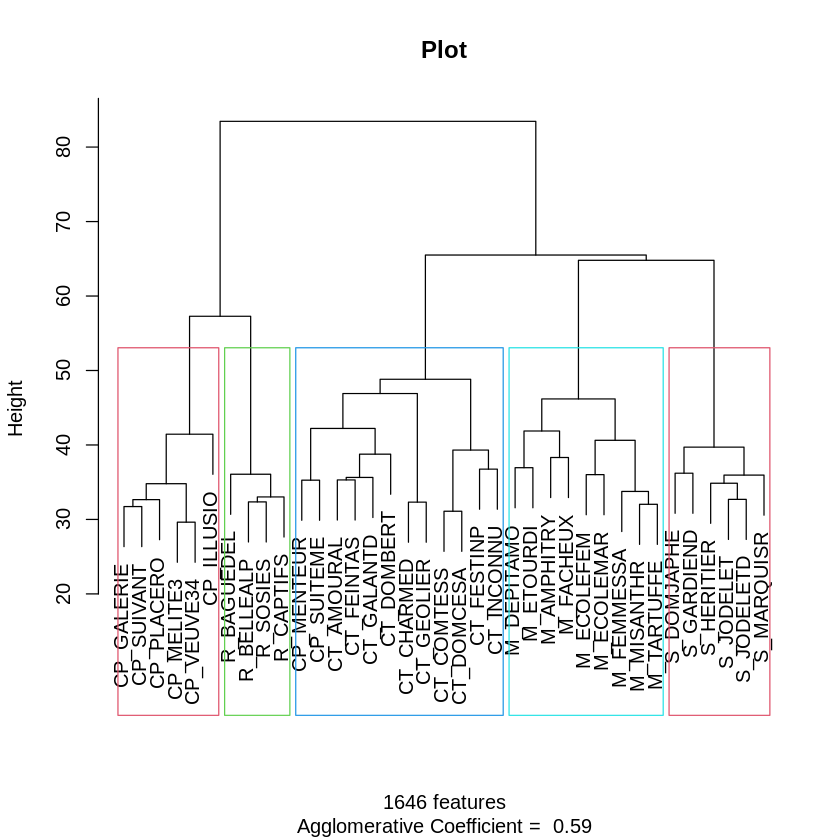

In [ ]:
theatreAllWords <- as.matrix(read.csv("explorat-words.csv", sep = ";", header = TRUE, row.names = 1, quote="\""))
theatre <- theatreAllWords[, subgroup]
theatre <- theatre[!rownames(theatre) %in% suspectedProperNames, ]
theatre <- theatre[rowSums(theatre) > 0, ]

theatreAffs <- countAffixes(theatre)

select <- selection(theatreAffs, z = 1.645)[,4]

theatre2 <- relativeFreqs(theatreAffs)
theatreAffixesSave <- theatre2
theatre2 <- theatre2[select, ]
theatre2 <- normalisations(theatre2)

CAHAffs <- cluster::agnes(t(theatre2), metric = "manhattan", method = "ward")

cahPlot(CAHAffs, k = 5)

## Clustering sur les affixes : synthèse

### Ce que fait la cellule
- On part d'une matrice de **mots** (comptages par texte), on garde le même **sous-corpus** (`subgroup`) et on enlève les **noms propres**.
- On transforme ensuite les mots en **affixes** (préfixes/suffixes) avec `countAffixes()` :  
  on ne regarde plus *quels mots* sont utilisés, mais plutôt des **morceaux de mots** (indices de morphologie).
- Puis, comme d'habitude :
  - on sélectionne les affixes les plus informatifs,
  - on passe en **fréquences relatives**,
  - on **normalise**,
  - et on fait un **clustering hiérarchique** (dendrogramme découpé en 5 groupes).


### Ce qu'on observe (interprétation)
Le clustering sur les **affixes** donne des groupes très clairs, proches des auteurs :

- **Cluster CorneilleP (Pierre Corneille)**  
  Plusieurs pièces de CorneilleP se regroupent nettement, et *Illusion comique* tombe aussi dans ce groupe.  
Signal "Pierre Corneille" bien identifié.

- **Cluster Rotrou**  
  Les pièces de Rotrou sont regroupées ensemble.  
Cluster très net.

- **Cluster Thomas Corneille**  
  Un gros paquet de pièces `CORNEILLET_...` se retrouve ensemble.  
Signal “Thomas Corneille” très fort.

- **Cluster Molière**  
  Les pièces de Molière se regroupent dans un même ensemble cohérent.  
Molière ressort clairement comme un cluster stable.

- **Cluster Scarron**  
  Les pièces de Scarron sont groupées ensemble.  
Scarron ressort très bien.


### Pourquoi c'est intéressant
- Les **affixes** captent des habitudes de **morphologie** (façons de former des mots, dérivation, suffixation, etc.).
- Ce sont des traits souvent moins liés au sujet immédiat, et donc utiles pour repérer des régularités de style.
- Ici, le résultat est très parlant : **les auteurs se séparent bien**, ce qui confirme que le signal stylométrique est robuste, même avec un type de traits différent des mots ou des lemmes.


## Pour résumer :    
### L'intérêt du notebook :    
C'est une démonstration **robuste** parce qu'elle teste plusieurs familles d'indices stylistiques (lexique, rimes, formes, affixes, séquences morpho-syntaxiques/POS, mots-outils) et applique à chaque fois la même logique (fréquences → normalisations → clustering) pour voir si les regroupements "retombent" sur les auteurs.
### L'intérêt du papier :      
Il réévalue, avec des méthodes d'attribution d'auteur plus "state of the art", la controverse médiatisée "Corneille aurait écrit Molière", et montre qu'avec un corpus bien contrôlé, **rien n'indique que Pierre (ou Thomas) Corneille ait écrit les pièces signées Molière**.